In [ ]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [ ]:
NUM_WORDS = 1000
EMBEDDING_DIM = 100
MAXLEN = 16
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8
TRUNCATING = 'post'
MAX_EXAMPLES = 160000

In [ ]:
df = pd.read_csv("/content/sample_data/re_dataset_two_labels.csv")
print(df)

      Label                                              Tweet
0         2  - Dia sendiri yang ngiklanin promo cashback di...
1         2  - disaat semua cowok berusaha melacak perhatia...
2         2  - kampret kan kalo typo-nya di email kantor ke...
3         2  - Mending makan disini lebih murah, buang-buan...
4         2  /biarin oppa masukim vibrator ke memek/ oppa k...
...     ...                                                ...
2011      2  Yagimanasih anjir gue dirumah doang dari pagi ...
2012      1  Yah sekian pandangan awam dari saya wkwwk seka...
2013      2       yang butuh memek hubungi rp haneul terdekat'
2014      2  Yang sabar gua mah punya adek2 kunyuk yg bau k...
2015      2  yg didepan pada minggir buat ngasih jalan yg t...

[2016 rows x 2 columns]


In [ ]:
def remove_stopwords(sentence):
  stopwords = []
  with open("/content/sample_data/kamus_belanja.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      stopwords.append(row)
  
  sentence = sentence.lower()
  words = sentence.split()
  no_words = [w for w in words if w not in stopwords]
  sentence = " ".join(no_words)
  
  return sentence

In [ ]:
def parse_dataset(filename) :
  sentences = []
  labels = []
  
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      labels.append(row[0])
      sentence = row[1]
      sentence = remove_stopwords(sentence)
      sentences.append(sentence)
  
  return sentences, labels

In [ ]:
sentences, labels = parse_dataset("/content/sample_data/re_dataset_two_labels.csv")

In [ ]:
def train_val_split(sentences, labels, training_split):
  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[0:train_size]
  train_labels = labels[0:train_size]
  validation_sentences = sentences[train_size:]
  validation_labels = labels[train_size:]

  return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

In [ ]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
  tokenizer.fit_on_texts(train_sentences)
  return tokenizer

In [ ]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 6761 words

<OOV> token included in vocabulary


In [ ]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  padded_sequences = pad_sequences(sequences, maxlen=MAXLEN, padding=PADDING)
  
  return padded_sequences

In [ ]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

In [ ]:
def tokenize_labels(all_labels, split_labels):
  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(all_labels)
  label_seq = label_tokenizer.texts_to_sequences(split_labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np

In [ ]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

In [ ]:
def create_model(num_words, embedding_dim, maxlen):
  tf.random.set_seed(24)

  model = tf.keras.Sequential([tf.keras.layers.Embedding(10000,embedding_dim,input_length=maxlen),
                               tf.keras.layers.GlobalAveragePooling1D(),
                               tf.keras.layers.Dense(1, activation="sigmoid"),
                               tf.keras.layers.Dense(24, activation='softmax')                              
                                                    ])
  
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/20
51/51 [==============================] - 3s 32ms/step - loss: 3.2239 - accuracy: 0.0000e+00 - val_loss: 3.1333 - val_accuracy: 0.0000e+00
Epoch 2/20
51/51 [==============================] - 1s 23ms/step - loss: 3.0746 - accuracy: 0.0521 - val_loss: 3.0085 - val_accuracy: 0.2574
Epoch 3/20
51/51 [==============================] - 1s 23ms/step - loss: 2.9606 - accuracy: 0.4448 - val_loss: 2.9110 - val_accuracy: 0.7302
Epoch 4/20
51/51 [==============================] - 1s 26ms/step - loss: 2.8653 - accuracy: 0.8486 - val_loss: 2.8211 - val_accuracy: 0.7426
Epoch 5/20
51/51 [==============================] - 1s 24ms/step - loss: 2.7752 - accuracy: 0.8579 - val_loss: 2.7334 - val_accuracy: 0.7426
Epoch 6/20
51/51 [==============================] - 1s 25ms/step - loss: 2.6866 - accuracy: 0.8592 - val_loss: 2.6456 - val_accuracy: 0.7426
Epoch 7/20
51/51 [==============================] - 1s 25ms/step - loss: 2.5964 - accuracy: 0.8592 - val_loss: 2.5493 - val_accuracy: 0.7401
Epoch

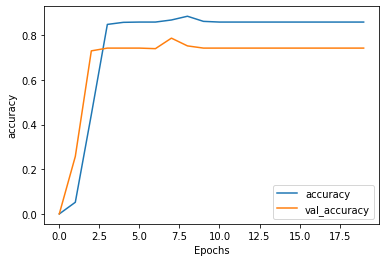

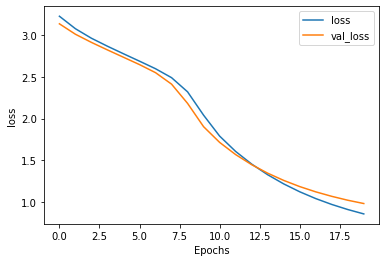

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save("/content/drive/My Drive/model.h5")

Mounted at /content/drive
